# Data Pipeline: Scalar Acceleration Analysis from PX4 ULog

This tutorial outlines a data pipeline designed to calculate scalar acceleration from PX4 ULog files and compute its summary statistics.

We can analyze a drone's flight performance and identify potential issues with erratic movements.

In [1]:
import os
from pathlib import Path

current_dir = Path.cwd()
project_root = None

while current_dir != current_dir.parent:
    if (current_dir / '.git').exists():
        project_root = current_dir
        break
    current_dir = current_dir.parent

os.chdir(project_root)

We use the `run` command to execute a data pipeline on a robolog.

In [2]:
!poetry run python3 main.py run --help

                                                                                
 Usage: main.py run [OPTIONS] PIPELINE_PATH ROBOLOG_PATH                        
                                                                                
 Run data pipeline defined in the YAML file on the provided robolog.            
                                                                                
                                                                                
╭─ Arguments ──────────────────────────────────────────────────────────────────╮
│ *    pipeline_path      PATH  Path to the pipeline definition YAML file      │
│                               [required]                                     │
│ *    robolog_path       PATH  Path to the robolog [required]                 │
╰──────────────────────────────────────────────────────────────────────────────╯
╭─ Options ────────────────────────────────────────────────────────────────────╮
│ --start-seconds           

Let's inspect the pipeline definition, which is a YAML file with a specific structure.

In [3]:
!cat ./doc/tutorials/pipelines/acceleration.yaml

extract_topic:
  - name: raw_messages
    topics:
      - vehicle_acceleration_0

transform_dataframe:
  - name: acceleration
    sql: |
      SELECT
        "vehicle_acceleration_0"."xyz[0]" AS x,
        "vehicle_acceleration_0"."xyz[1]" AS y,
        "vehicle_acceleration_0"."xyz[2]" AS z
      FROM raw_messages

  - name: scalar
    sql: |
      SELECT
        SQRT(x ** 2 + y ** 2 + z ** 2) AS magnitude
      FROM acceleration

  - name: statistics
    sql: |
      SELECT
        MIN(magnitude) AS min_magnitude,
        MAX(magnitude) AS max_magnitude,
        AVG(magnitude) AS avg_magnitude
      FROM scalar

save_dataframe:
  - acceleration
  - scalar
  - statistics


### Pipeline Definition Breakdown

This section details each stage of the data processing pipeline. The pipeline is defined by a series of operators that extract, transform, and save the data.

#### 1\. `extract_topic`

First, the `extract_topic` operator reads messages from the `vehicle_acceleration_0` topic. The resulting data is loaded into a DataFrame named `raw_messages`.

```yaml
extract_topic:
  - name: raw_messages
    topics:
      - vehicle_acceleration_0
```

#### 2\. `transform_dataframe`

Next, the `transform_dataframe` operator executes a sequence of three SQL transformations. This operator takes the `raw_messages` DataFrame as input and generates three distinct DataFrames: `acceleration`, `scalar`, and `statistics`.

```yaml
transform_dataframe:
  - name: acceleration
    sql: |
      SELECT
        "vehicle_acceleration_0"."xyz[0]" AS x,
        "vehicle_acceleration_0"."xyz[1]" AS y,
        "vehicle_acceleration_0"."xyz[2]" AS z
      FROM raw_messages

  - name: scalar
    sql: |
      SELECT
        SQRT(x * x + y * y + z * z) AS magnitude
      FROM acceleration

  - name: statistics
    sql: |
      SELECT
        MIN(magnitude) AS min_magnitude,
        MAX(magnitude) AS max_magnitude,
        AVG(magnitude) AS avg_magnitude
      FROM scalar
```

The transformation process occurs in three steps:

1.  **Creating `acceleration`**: The first transformation extracts the `xyz[0]`, `xyz[1]`, and `xyz[2]` fields from the initial `raw_messages` DataFrame. It renames these fields to `x`, `y`, and `z`, respectively, creating the `acceleration` DataFrame.
2.  **Creating `scalar`**: The second transformation takes the `acceleration` DataFrame and calculates the scalar acceleration (Euclidean norm) for each row. The resulting column is named `magnitude`, which produces the `scalar` DataFrame.
3.  **Creating `statistics`**: The final transformation calculates the minimum, maximum, and average values from the `magnitude` column in the `scalar` DataFrame. This produces the final `statistics` DataFrame.

#### 3\. `save_dataframe`

Finally, the `save_dataframe` operator saves the `acceleration`, `scalar`, and `statistics` DataFrames to local storage.

```yaml
save_dataframe:
  - acceleration
  - scalar
  - statistics
```

### Let's run this pipeline.

In [4]:
!poetry run python3 main.py run ./doc/tutorials/pipelines/acceleration.yaml ./doc/tutorials/data/px4.ulg

⢋⠁ Extracting messages from 1 topics into raw_messages                            
✅ Extracted messages from 1 topics into raw_messages                           
⢀⠀ Writing SQL query result into acceleration                                   
✅ Wrote SQL query result into acceleration                                     
⢀⠀ Writing SQL query result into scalar                                         
✅ Wrote SQL query result into scalar                                           
⢀⠀ Writing SQL query result into statistics                                     
✅ Wrote SQL query result into statistics                                       
⢋⠠ Saving acceleration to disk                                                    
💾 Saved acceleration to                                                        
/home/shouheng/.bagel/datasets/acceleration/datestr=1969-12-31/snippet_bd63df32_
0.364_387.996.parquet                                                           
⠈⡙ Saving scalar to disk     

In [5]:
import pandas as pd

df_acceleration = pd.read_parquet("/home/shouheng/.bagel/datasets/acceleration/datestr=1969-12-31/snippet_bd63df32_0.364_387.996.parquet")

df_acceleration

,x,y,z
0,-0.006750,-0.002023,-7.339376
1,-0.007663,-0.001992,-9.797578
2,-0.006243,0.000062,-9.807760
3,-0.006263,0.001895,-9.802317
4,-0.007040,-0.000961,-9.805594
...,...,...,...
7749,0.073445,-0.003988,-9.834057
7750,0.073092,-0.001574,-9.833152
7751,0.088183,-0.000450,-9.842745
7752,0.084393,0.000348,-9.843134


<Axes: >

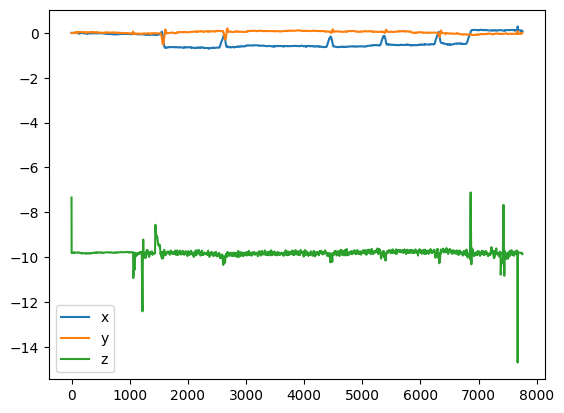

In [6]:
df_acceleration.plot()

In [7]:
df_scalar = pd.read_parquet("/home/shouheng/.bagel/datasets/scalar/datestr=1969-12-31/snippet_bd63df32_0.364_387.996.parquet")

df_scalar

,magnitude
0,7.339379
1,9.797581
2,9.807762
3,9.802319
4,9.805597
...,...
7749,9.834332
7750,9.833424
7751,9.843140
7752,9.843496


<Axes: >

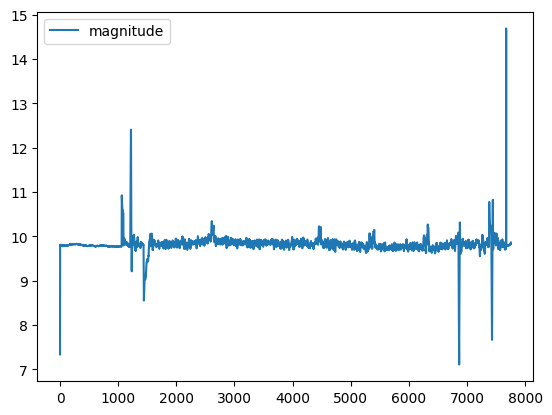

In [8]:
df_scalar.plot()

In [9]:
pd.read_parquet("/home/shouheng/.bagel/datasets/statistics/datestr=1969-12-31/snippet_bd63df32_0.364_387.996.parquet")

,min_magnitude,max_magnitude,avg_magnitude
0,7.111211,14.692728,9.822003
